In [17]:
import numpy as np
import pandas as pd

import scipy.stats as st

from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import matplotlib as mpl
sns.set_style('white')
mpl.rcParams['pdf.fonttype'] = 42

In [8]:
tools = ['Network&AA', 'CHASM', 'ParsSNP', 'CanDrA', 'TransFIC',
         'VEST', 'SIFT', 'PolyPhen', 'CADD', 'ClinPred',
         'DANN', 'DEOGEN2', 'FATHMM', 'LIST-S2', 'LRT',
         'M-CAP', 'MPC', 'MVP', 'MetaLR', 'MetaSVM',
         'MutPred','MutationAssessor', 'MutationTaster', 'PROVEAN', 'REVEL']
print('# tools compared for Figure 8: %s' % len(tools))
tools_pred = ['SIFT_pred', 'PolyPhen_pred', 'ClinPred_pred', 'DEOGEN2_pred', 'FATHMM_pred',
              'LIST-S2_pred', 'LRT_pred', 'M-CAP_pred', 'MetaLR_pred', 'MetaSVM_pred',
              'MutationAssessor_pred', 'MutationTaster_pred', 'PROVEAN_pred']
tools_add = ['CHASMplus','Suspect']
tools_all = tools+tools_add
tools_net = ['Network&AA','CHASMplus','Suspect']
print('# tools compared for Figure S4: %s' % len(tools_net))

# tools compared for Figure 8: 25
# tools compared for Figure S4: 3


In [50]:
metrics_arr = ['auROC','auPR','Accuracy','F1','MCC']

### Functions

In [10]:
def get_pred_bytool(tool, preds):
    if tool in ['ClinPred','DEOGEN2','FATHMM','LIST-S2','LRT','M-CAP','MetaLR','MetaSVM','PROVEAN']:
        return [1 if pred=='D' else 0 for pred in preds]
    elif tool=='SIFT':
        return [1 if pred in ['deleterious','deleterious_low_confidence'] else 0 for pred in preds]
    elif tool=='PolyPhen':
        return [1 if pred in ['probably_damaging','possibly_damaging'] else 0 for pred in preds]
    elif tool=='MutationAssessor':
        return [1 if pred in ['H','M'] else 0 for pred in preds]
    elif tool=='MutationTaster':
        return [1 if pred in ['A','D'] else 0 for pred in preds]
    elif tool=='ParsSNP':
        return [1 if pred>=0.1 else 0 for pred in preds]
    elif tool=='MVP':
        return [1 if pred>=0.7 else 0 for pred in preds]
    elif tool=='Suspect':
        return [1 if pred>=50 else 0 for pred in preds] 
    else:
        return [1 if pred>=0.5 else 0 for pred in preds]

In [11]:
def compute_performance(label, pred, score):
    auROC = metrics.roc_auc_score(label, score)
    auPR = metrics.average_precision_score(label, score)
    accuracy = metrics.accuracy_score(label, pred)
    f1 = metrics.f1_score(label, pred)
    mcc = metrics.matthews_corrcoef(label, pred)
    return [auROC, auPR, accuracy, f1, mcc]

In [26]:
# Functions for DeLong test
def group_preds_by_label(preds, actual):
    X = [p for (p, a) in zip(preds, actual) if a]
    Y = [p for (p, a) in zip(preds, actual) if not a]
    return X, Y

def auc(X, Y):
    return 1/(len(X)*len(Y)) * sum([kernel(x, y) for x in X for y in Y])

def kernel(X, Y):
    return .5 if Y==X else int(Y < X)

def structural_components(X, Y):
    V10 = [1/len(Y) * sum([kernel(x, y) for y in Y]) for x in X]
    V01 = [1/len(X) * sum([kernel(x, y) for x in X]) for y in Y]
    return V10, V01
    
def get_S_entry(V_A, V_B, auc_A, auc_B):
    return 1/(len(V_A)-1) * sum([(a-auc_A)*(b-auc_B) for a,b in zip(V_A, V_B)])

def z_score(var_A, var_B, covar_AB, auc_A, auc_B):
    return (auc_A - auc_B)/((var_A + var_B - 2*covar_AB)**(.5))

## Benchmark sets

### Kim et al.

In [22]:
setname = 'kim_et_al'
df = pd.read_table('../data/benchmark/%s_predictions.txt' % setname)
print(df.shape)
# Only extract mutations with predictions from all methods
df = df.dropna()
print(df.shape)
df.head()

(71, 48)
(32, 48)


,UID,Unip,Hugo_Symbol,Accession,HGVSp_Short,AA_Change,class,y,Network&AA,CHASM,...,LIST-S2_pred,LRT_pred,M-CAP_pred,MetaLR_pred,MetaSVM_pred,MutationAssessor_pred,MutationTaster_pred,PROVEAN_pred,CHASMplus,Suspect
2,2,P31749,AKT1,ENST00000349310,p.E267G,E267G,functional,1,0.226,0.784,...,D,D,D,T,T,L,D,D,0.42714,84
6,6,P31749,AKT1,ENST00000349310,p.V201I,V201I,neutral,0,0.327,0.572,...,D,D,D,T,T,N,D,N,0.29862,94
14,14,Q969H0,FBXW7,ENST00000281708,p.S462Y,S462Y,neutral,0,0.819,0.508,...,D,D,D,T,T,M,D,D,0.84898,37
16,16,O75874,IDH1,ENST00000345146,p.P33S,P33S,neutral,0,0.050,0.524,...,T,D,D,D,D,H,D,D,0.17460,34
17,17,O75874,IDH1,ENST00000345146,p.R132C,R132C,functional,1,0.756,0.504,...,D,D,D,D,D,H,D,D,0.95254,44


In [23]:
perform_df = pd.DataFrame(index=tools_all, columns=metrics_arr)
for tool in tools_all:
    pred_arr = list()
    if tool+'_pred' in tools_pred:
        pred_arr = get_pred_bytool(tool, df[tool+'_pred'].values)
    else:
        pred_arr = get_pred_bytool(tool, df[tool].values) 
    perform_df.loc[tool] = compute_performance(df['y'].values, pred_arr, df[tool].values)
perform_df.head()

/cellar/users/kivil/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


,auROC,auPR,Accuracy,F1,MCC
Network&AA,0.895455,0.951464,0.875,0.904762,0.731126
CHASM,0.706818,0.873457,0.65625,0.755556,0.178068
ParsSNP,0.822727,0.905841,0.78125,0.851064,0.458682
CanDrA,0.640909,0.752086,0.4375,0.4375,0.0181818
TransFIC,0.590909,0.7564,0.71875,0.816327,0.266919


In [24]:
perform_df.to_csv('../data/benchmark/%s_classifier_performance.txt' % setname,sep='\t')

#### Perform DeLong test to compare auROC values

In [28]:
out_arr = list()

# Model A vs. model B
preds_A = np.array(df['Network&AA'].values)
actual = np.array(df['y'].values)

for tool in tools_all[1:]:
    preds_B = np.array(df[tool].values)

    X_A, Y_A = group_preds_by_label(preds_A, actual)
    X_B, Y_B = group_preds_by_label(preds_B, actual)

    V_A10, V_A01 = structural_components(X_A, Y_A)
    V_B10, V_B01 = structural_components(X_B, Y_B)

    auc_A = auc(X_A, Y_A)
    auc_B = auc(X_B, Y_B)

    # Compute entries of covariance matrix S (covar_AB = covar_BA)
    var_A = (get_S_entry(V_A10, V_A10, auc_A, auc_A) * 1/len(V_A10)
             + get_S_entry(V_A01, V_A01, auc_A, auc_A) * 1/len(V_A01))
    var_B = (get_S_entry(V_B10, V_B10, auc_B, auc_B) * 1/len(V_B10)
             + get_S_entry(V_B01, V_B01, auc_B, auc_B) * 1/len(V_B01))
    covar_AB = (get_S_entry(V_A10, V_B10, auc_A, auc_B) * 1/len(V_A10)
                + get_S_entry(V_A01, V_B01, auc_A, auc_B) * 1/len(V_A01))

    # Two tailed test
    z = z_score(var_A, var_B, covar_AB, auc_A, auc_B)
    p = st.norm.sf(abs(z))*2
    
    out_arr.append([tool, z*-1, p])

delong_df = pd.DataFrame(out_arr, columns=['Method','z-score','p-value'])
delong_df.head()

,Method,z-score,p-value
0,CHASM,-1.594180,0.110896
1,ParsSNP,-0.698498,0.484866
2,CanDrA,-1.842518,0.065399
3,TransFIC,-2.691577,0.007112
4,VEST,-2.468865,0.013554


In [29]:
delong_df.to_csv('../data/benchmark/%s_delong_test.txt' % setname, sep='\t', index=False)

### Ng et al.

In [31]:
setname = 'ng_et_al'
df = pd.read_table('../data/benchmark/%s_predictions.txt' % setname)
print(df.shape)
# Only extract mutations with class value 'activating' or 'neutral'
df = df[df['y'].isin([0,1])]
print(df.shape)
# Only extract mutations with predictions from all methods
df = df.dropna()
print(df.shape)
df.head()

(903, 48)
(740, 48)
(275, 48)


,UID,Unip,Hugo_Symbol,Accession,HGVSp_Short,AA_Change,class,y,Network&AA,CHASM,...,LIST-S2_pred,LRT_pred,M-CAP_pred,MetaLR_pred,MetaSVM_pred,MutationAssessor_pred,MutationTaster_pred,PROVEAN_pred,CHASMplus,Suspect
34,34,P10398,ARAF,ENST00000377045,p.D402N,D402N,neutral,0.0,0.255,0.690,...,D,D,D,T,T,N,D,N,0.1463,22.0
35,35,P10398,ARAF,ENST00000377045,p.E568Q,E568Q,neutral,0.0,0.228,0.714,...,D,D,D,T,T,L,D,D,0.3080,25.0
36,36,P10398,ARAF,ENST00000377045,p.G446D,G446D,neutral,0.0,0.487,0.824,...,D,D,D,D,D,M,D,D,0.3476,85.0
37,37,P10398,ARAF,ENST00000377045,p.G459W,G459W,neutral,0.0,0.229,0.584,...,D,D,D,D,D,M,D,D,0.3124,24.0
38,38,P10398,ARAF,ENST00000377045,p.G496E,G496E,neutral,0.0,0.490,0.844,...,D,D,D,D,D,H,D,D,0.3839,90.0


In [32]:
perform_df = pd.DataFrame(index=tools_all, columns=metrics_arr)
for tool in tools_all:
    pred_arr = list()
    if tool+'_pred' in tools_pred:
        pred_arr = get_pred_bytool(tool, df[tool+'_pred'].values)
    else:
        pred_arr = get_pred_bytool(tool, df[tool].values) 
    perform_df.loc[tool] = compute_performance(df['y'].values, pred_arr, df[tool].values)
perform_df.head()

,auROC,auPR,Accuracy,F1,MCC
Network&AA,0.824989,0.819014,0.785455,0.70936,0.539538
CHASM,0.54019,0.397174,0.56,0.421053,0.0663496
ParsSNP,0.810002,0.755387,0.767273,0.648352,0.488334
CanDrA,0.561639,0.433828,0.545455,0.358974,0.00862748
TransFIC,0.484618,0.395188,0.487273,0.438247,-0.00652126


In [33]:
perform_df.to_csv('../data/benchmark/%s_classifier_performance.txt' % setname,sep='\t')

#### Perform DeLong test to compare auROC values

In [34]:
out_arr = list()

# Model A vs. model B
preds_A = np.array(df['Network&AA'].values)
actual = np.array(df['y'].values)

for tool in tools_all[1:]:
    preds_B = np.array(df[tool].values)

    X_A, Y_A = group_preds_by_label(preds_A, actual)
    X_B, Y_B = group_preds_by_label(preds_B, actual)

    V_A10, V_A01 = structural_components(X_A, Y_A)
    V_B10, V_B01 = structural_components(X_B, Y_B)

    auc_A = auc(X_A, Y_A)
    auc_B = auc(X_B, Y_B)

    # Compute entries of covariance matrix S (covar_AB = covar_BA)
    var_A = (get_S_entry(V_A10, V_A10, auc_A, auc_A) * 1/len(V_A10)
             + get_S_entry(V_A01, V_A01, auc_A, auc_A) * 1/len(V_A01))
    var_B = (get_S_entry(V_B10, V_B10, auc_B, auc_B) * 1/len(V_B10)
             + get_S_entry(V_B01, V_B01, auc_B, auc_B) * 1/len(V_B01))
    covar_AB = (get_S_entry(V_A10, V_B10, auc_A, auc_B) * 1/len(V_A10)
                + get_S_entry(V_A01, V_B01, auc_A, auc_B) * 1/len(V_A01))

    # Two tailed test
    z = z_score(var_A, var_B, covar_AB, auc_A, auc_B)
    p = st.norm.sf(abs(z))*2
    
    out_arr.append([tool, z*-1, p])

delong_df = pd.DataFrame(out_arr, columns=['Method','z-score','p-value'])
delong_df.head()

,Method,z-score,p-value
0,CHASM,-5.822701,5.790426e-09
1,ParsSNP,-0.680182,4.963895e-01
2,CanDrA,-6.652917,2.873406e-11
3,TransFIC,-7.455257,8.969306e-14
4,VEST,-3.450394,5.597687e-04


In [35]:
delong_df.to_csv('../data/benchmark/%s_delong_test.txt' % setname, sep='\t', index=False)

### MSK-IMPACT

In [36]:
setname = 'msk_impact'
df = pd.read_table('../data/benchmark/%s_predictions.txt' % setname)
print(df.shape)
# Only extract mutations with predictions from all methods
df = df.dropna()
print(df.shape)
df.head()

(36529, 48)
(13639, 48)


,UID,Unip,Hugo_Symbol,Accession,HGVSp_Short,AA_Change,class,y,Network&AA,CHASM,...,LIST-S2_pred,LRT_pred,M-CAP_pred,MetaLR_pred,MetaSVM_pred,MutationAssessor_pred,MutationTaster_pred,PROVEAN_pred,CHASMplus,Suspect
14,17,P42336,PIK3CA,ENST00000263967,p.E545K,E545K,Oncogenic,1,0.980,0.706,...,D,D,D,T,T,L,D,D,0.841752,55.0
15,18,P03372,ESR1,ENST00000206249,p.L536H,L536H,Likely Oncogenic,1,0.632,0.468,...,D,D,D,D,D,M,D,D,0.316496,98.0
16,19,P11802,CDK4,ENST00000257904,p.D196H,D196H,-,0,0.484,0.728,...,D,D,D,D,D,H,D,D,0.204740,99.0
17,20,P04637,TP53,ENST00000269305,p.R248W,R248W,Likely Oncogenic,1,0.983,0.718,...,D,D,D,D,D,M,A,D,0.831420,100.0
18,21,Q68DV7,RNF43,ENST00000407977,p.W194S,W194S,-,0,0.165,0.346,...,T,N,T,T,T,N,D,D,0.386308,41.0


In [37]:
perform_df = pd.DataFrame(index=tools_all, columns=metrics_arr)
for tool in tools_all:
    pred_arr = list()
    if tool+'_pred' in tools_pred:
        pred_arr = get_pred_bytool(tool, df[tool+'_pred'].values)
    else:
        pred_arr = get_pred_bytool(tool, df[tool].values) 
    perform_df.loc[tool] = compute_performance(df['y'].values, pred_arr, df[tool].values)
perform_df.head()

,auROC,auPR,Accuracy,F1,MCC
Network&AA,0.838535,0.175643,0.901972,0.237307,0.26173
CHASM,0.635456,0.0421344,0.587213,0.0740132,0.0722983
ParsSNP,0.80654,0.134673,0.900433,0.218642,0.236028
CanDrA,0.774867,0.10145,0.769924,0.107001,0.116578
TransFIC,0.746872,0.0639945,0.48244,0.0826511,0.119178


In [38]:
perform_df.to_csv('../data/benchmark/%s_classifier_performance.txt' % setname,sep='\t')

#### Perform DeLong test to compare auROC values

In [39]:
out_arr = list()

# Model A vs. model B
preds_A = np.array(df['Network&AA'].values)
actual = np.array(df['y'].values)

for tool in tools_all[1:]:
    preds_B = np.array(df[tool].values)

    X_A, Y_A = group_preds_by_label(preds_A, actual)
    X_B, Y_B = group_preds_by_label(preds_B, actual)

    V_A10, V_A01 = structural_components(X_A, Y_A)
    V_B10, V_B01 = structural_components(X_B, Y_B)

    auc_A = auc(X_A, Y_A)
    auc_B = auc(X_B, Y_B)

    # Compute entries of covariance matrix S (covar_AB = covar_BA)
    var_A = (get_S_entry(V_A10, V_A10, auc_A, auc_A) * 1/len(V_A10)
             + get_S_entry(V_A01, V_A01, auc_A, auc_A) * 1/len(V_A01))
    var_B = (get_S_entry(V_B10, V_B10, auc_B, auc_B) * 1/len(V_B10)
             + get_S_entry(V_B01, V_B01, auc_B, auc_B) * 1/len(V_B01))
    covar_AB = (get_S_entry(V_A10, V_B10, auc_A, auc_B) * 1/len(V_A10)
                + get_S_entry(V_A01, V_B01, auc_A, auc_B) * 1/len(V_A01))

    # Two tailed test
    z = z_score(var_A, var_B, covar_AB, auc_A, auc_B)
    p = st.norm.sf(abs(z))*2
    
    out_arr.append([tool, z*-1, p])

delong_df = pd.DataFrame(out_arr, columns=['Method','z-score','p-value'])
delong_df.head()

,Method,z-score,p-value
0,CHASM,-10.383859,2.936609e-25
1,ParsSNP,-2.913933,3.569070e-03
2,CanDrA,-5.284538,1.260222e-07
3,TransFIC,-5.958144,2.551192e-09
4,VEST,-4.406355,1.051244e-05


In [40]:
delong_df.to_csv('../data/benchmark/%s_delong_test.txt' % setname, sep='\t', index=False)

### CGC-recurrent

In [41]:
setname = 'cgc_recurrent'
df = pd.read_table('../data/benchmark/%s_predictions.txt' % setname)
print(df.shape)
# Only extract mutations with predictions from all methods
df = df.dropna()
print(df.shape)
df.head()

(284928, 48)
(100903, 48)


,UID,Unip,Hugo_Symbol,Accession,HGVSp_Short,AA_Change,class,y,Network&AA,CHASM,...,LIST-S2_pred,LRT_pred,M-CAP_pred,MetaLR_pred,MetaSVM_pred,MutationAssessor_pred,MutationTaster_pred,PROVEAN_pred,CHASMplus,Suspect
0,3,P17947,SPI1,ENST00000378538,p.P127T,P127T,likely neutral,0,0.007,0.292,...,T,N,T,T,T,L,D,N,0.052628,17.0
3,11,O00423,EML1,ENST00000262233,p.A287T,A287T,likely neutral,0,0.007,0.420,...,D,D,D,D,D,H,D,D,0.014080,89.0
12,47,Q149N8,SHPRH,ENST00000275233,p.E342K,E342K,likely neutral,0,0.000,0.264,...,D,N,T,T,T,N,D,N,0.010920,4.0
14,50,Q15375,EPHA7,ENST00000369303,p.R69Q,R69Q,likely neutral,0,0.031,0.570,...,D,D,D,T,T,M,D,N,0.094724,48.0
20,66,P16219,ACADS,ENST00000242592,p.A331T,A331T,likely neutral,0,0.038,0.484,...,D,D,D,D,D,M,D,D,0.456984,51.0


In [42]:
perform_df = pd.DataFrame(index=tools_all, columns=metrics_arr)
for tool in tools_all:
    pred_arr = list()
    if tool+'_pred' in tools_pred:
        pred_arr = get_pred_bytool(tool, df[tool+'_pred'].values)
    else:
        pred_arr = get_pred_bytool(tool, df[tool].values) 
    perform_df.loc[tool] = compute_performance(df['y'].values, pred_arr, df[tool].values)
perform_df.head()

,auROC,auPR,Accuracy,F1,MCC
Network&AA,0.774887,0.33879,0.980784,0.368198,0.360839
CHASM,0.653641,0.031881,0.714409,0.0571279,0.065639
ParsSNP,0.802379,0.237317,0.981477,0.363636,0.359269
CanDrA,0.686772,0.0674637,0.866872,0.0787326,0.0821884
TransFIC,0.657937,0.0355489,0.506258,0.0460325,0.0536627


In [43]:
perform_df.to_csv('../data/benchmark/%s_classifier_performance.txt' % setname,sep='\t')

#### Perform DeLong test to compare auROC values

In [95]:
out_arr = list()

# Model A vs. model B
preds_A = np.array(df['Network&AA'].values)
actual = np.array(df['y'].values)

for tool in tools_all[1:]:
    preds_B = np.array(df[tool].values)

    X_A, Y_A = group_preds_by_label(preds_A, actual)
    X_B, Y_B = group_preds_by_label(preds_B, actual)

    V_A10, V_A01 = structural_components(X_A, Y_A)
    V_B10, V_B01 = structural_components(X_B, Y_B)

    auc_A = auc(X_A, Y_A)
    auc_B = auc(X_B, Y_B)

    # Compute entries of covariance matrix S (covar_AB = covar_BA)
    var_A = (get_S_entry(V_A10, V_A10, auc_A, auc_A) * 1/len(V_A10)
             + get_S_entry(V_A01, V_A01, auc_A, auc_A) * 1/len(V_A01))
    var_B = (get_S_entry(V_B10, V_B10, auc_B, auc_B) * 1/len(V_B10)
             + get_S_entry(V_B01, V_B01, auc_B, auc_B) * 1/len(V_B01))
    covar_AB = (get_S_entry(V_A10, V_B10, auc_A, auc_B) * 1/len(V_A10)
                + get_S_entry(V_A01, V_B01, auc_A, auc_B) * 1/len(V_A01))

    # Two tailed test
    z = z_score(var_A, var_B, covar_AB, auc_A, auc_B)
    p = st.norm.sf(abs(z))*2
    
    out_arr.append([tool, z*-1, p])

delong_df = pd.DataFrame(out_arr, columns=['Method','z-score','p-value'])
delong_df.head()

,Method,z-score,p-value
0,CHASM,-14.202463,8.844874e-46
1,ParsSNP,3.713905,2.040856e-04
2,CanDrA,-13.709331,8.927714e-43
3,TransFIC,-16.247901,2.311427e-59
4,VEST,-14.282717,2.804494e-46


In [96]:
delong_df.to_csv('../data/benchmark/%s_delong_test.txt' % setname, sep='\t', index=False)

### Combine performances

In [47]:
setname = 'kim_et_al'
kim_df = pd.read_table('../data/benchmark/%s_classifier_performance.txt' % setname, index_col=0)
print(kim_df.shape)
setname = 'ng_et_al'
ng_df = pd.read_table('../data/benchmark/%s_classifier_performance.txt' % setname, index_col=0)
print(ng_df.shape)
setname = 'msk_impact'
msk_df = pd.read_table('../data/benchmark/%s_classifier_performance.txt' % setname, index_col=0)
print(msk_df.shape)
setname = 'cgc_recurrent'
cgc_df = pd.read_table('../data/benchmark/%s_classifier_performance.txt' % setname, index_col=0)
print(cgc_df.shape)

(27, 5)
(27, 5)
(27, 5)
(27, 5)


In [49]:
dataset_arr = ['kim','ng','msk','cgc']
dataset_dict = {'kim':'Kim et al.',
               'ng':'Ng et al.',
               'msk':'MSK\nIMPACT',
               'cgc':'CGC\nrecurrent'}
metrics_arr = list(cgc_df.columns)
print(metrics_arr)

['auROC', 'auPR', 'Accuracy', 'F1', 'MCC']


In [69]:
out_arr = list()
for d in dataset_arr:
    d_df = eval(d+'_df').copy()
    for t in tools:
        for m in metrics_arr:
            s = d_df.loc[t][m]
            out_arr.append([dataset_dict[d],t,m,s])
combine_df = pd.DataFrame(out_arr, columns=['dataset','tool','metric','score'])
print(len(combine_df))

out_arr = list()
for t in tools:
    for m in metrics_arr:
        s = np.mean(combine_df[(combine_df['tool']==t)&(combine_df['metric']==m)]['score'].values)
        out_arr.append(['mean',t,m,s])
temp_df = pd.DataFrame(out_arr, columns=['dataset','tool','metric','score'])
combine_df = pd.concat([combine_df, temp_df], ignore_index=True)
print(len(combine_df))
combine_df.tail()

500
625


,dataset,tool,metric,score
620,mean,REVEL,auROC,0.695712
621,mean,REVEL,auPR,0.328897
622,mean,REVEL,Accuracy,0.624850
623,mean,REVEL,F1,0.384204
624,mean,REVEL,MCC,0.153912


In [70]:
metric = 'auROC'
temp_df = combine_df[(combine_df['dataset']=='mean')&(combine_df['metric']==metric)].copy()
tool_arr = temp_df.sort_values(['score'],ascending=False)['tool'].values
out_arr = list()
for d in dataset_arr:
    d_df = eval(d+'_df').copy()
    for t in tool_arr:
        for m in metrics_arr:
            s = d_df.loc[t][m]
            out_arr.append([dataset_dict[d],t,m,s])
merge_df = pd.DataFrame(out_arr, columns=['dataset','tool','metric','score'])
out_arr = list()
for t in tool_arr:
    for m in metrics_arr:
        s = np.mean(merge_df[(merge_df['tool']==t)&(merge_df['metric']==m)]['score'].values)
        out_arr.append(['Mean',t,m,s])
temp_df = pd.DataFrame(out_arr, columns=['dataset','tool','metric','score'])
merge_df = pd.concat([merge_df, temp_df], ignore_index=True)
auroc_df = merge_df.copy()

In [71]:
# Set up a palette for 25 tools
current_palette = sns.color_palette("tab10",10)+sns.color_palette("Set2",10)+sns.color_palette("husl",5)

color_dict = dict()
for i,tool in enumerate(tool_arr):
    color_dict[tool] = current_palette[i]
color_arr_roc = [color_dict[tool] for tool in tool_arr]

In [72]:
metric = 'auPR'
temp_df = combine_df[(combine_df['dataset']=='mean')&(combine_df['metric']==metric)].copy()
tool_arr = temp_df.sort_values(['score'],ascending=False)['tool'].values
color_arr = [color_dict[tool] for tool in tool_arr]
out_arr = list()
for d in dataset_arr:
    d_df = eval(d+'_df').copy()
    for t in tool_arr:
        for m in metrics_arr:
            s = d_df.loc[t][m]
            out_arr.append([dataset_dict[d],t,m,s])
merge_df = pd.DataFrame(out_arr, columns=['dataset','tool','metric','score'])
out_arr = list()
for t in tool_arr:
    for m in metrics_arr:
        s = np.mean(merge_df[(merge_df['tool']==t)&(merge_df['metric']==m)]['score'].values)
        out_arr.append(['Mean',t,m,s])
temp_df = pd.DataFrame(out_arr, columns=['dataset','tool','metric','score'])
merge_df = pd.concat([merge_df, temp_df], ignore_index=True)
auprc_df = merge_df.copy()
color_arr_pr = color_arr

In [73]:
metric = 'Accuracy'
temp_df = combine_df[(combine_df['dataset']=='mean')&(combine_df['metric']==metric)].copy()
tool_arr = temp_df.sort_values(['score'],ascending=False)['tool'].values
color_arr = [color_dict[tool] for tool in tool_arr]
out_arr = list()
for d in dataset_arr:
    d_df = eval(d+'_df').copy()
    for t in tool_arr:
        for m in metrics_arr:
            s = d_df.loc[t][m]
            out_arr.append([dataset_dict[d],t,m,s])
merge_df = pd.DataFrame(out_arr, columns=['dataset','tool','metric','score'])
out_arr = list()
for t in tool_arr:
    for m in metrics_arr:
        s = np.mean(merge_df[(merge_df['tool']==t)&(merge_df['metric']==m)]['score'].values)
        out_arr.append(['Mean',t,m,s])
temp_df = pd.DataFrame(out_arr, columns=['dataset','tool','metric','score'])
merge_df = pd.concat([merge_df, temp_df], ignore_index=True)
acc_df = merge_df.copy()
color_arr_acc = color_arr

In [74]:
metric = 'F1'
temp_df = combine_df[(combine_df['dataset']=='mean')&(combine_df['metric']==metric)].copy()
tool_arr = temp_df.sort_values(['score'],ascending=False)['tool'].values
color_arr = [color_dict[tool] for tool in tool_arr]
out_arr = list()
for d in dataset_arr:
    d_df = eval(d+'_df').copy()
    for t in tool_arr:
        for m in metrics_arr:
            s = d_df.loc[t][m]
            out_arr.append([dataset_dict[d],t,m,s])
merge_df = pd.DataFrame(out_arr, columns=['dataset','tool','metric','score'])
out_arr = list()
for t in tool_arr:
    for m in metrics_arr:
        s = np.mean(merge_df[(merge_df['tool']==t)&(merge_df['metric']==m)]['score'].values)
        out_arr.append(['Mean',t,m,s])
temp_df = pd.DataFrame(out_arr, columns=['dataset','tool','metric','score'])
merge_df = pd.concat([merge_df, temp_df], ignore_index=True)
f1_df = merge_df.copy()
color_arr_f1 = color_arr

In [75]:
metric = 'MCC'
temp_df = combine_df[(combine_df['dataset']=='mean')&(combine_df['metric']==metric)].copy()
tool_arr = temp_df.sort_values(['score'],ascending=False)['tool'].values
color_arr = [color_dict[tool] for tool in tool_arr]
out_arr = list()
for d in dataset_arr:
    d_df = eval(d+'_df').copy()
    for t in tool_arr:
        for m in metrics_arr:
            s = d_df.loc[t][m]
            out_arr.append([dataset_dict[d],t,m,s])
merge_df = pd.DataFrame(out_arr, columns=['dataset','tool','metric','score'])
out_arr = list()
for t in tool_arr:
    for m in metrics_arr:
        s = np.mean(merge_df[(merge_df['tool']==t)&(merge_df['metric']==m)]['score'].values)
        out_arr.append(['Mean',t,m,s])
temp_df = pd.DataFrame(out_arr, columns=['dataset','tool','metric','score'])
merge_df = pd.concat([merge_df, temp_df], ignore_index=True)
mcc_df = merge_df.copy()
color_arr_mcc = color_arr

### Figure 7

In [76]:
mpl.rc('legend', fontsize=7)
mpl.rc('xtick', labelsize=9)
mpl.rc('ytick', labelsize=9)
mpl.rc('axes', labelsize=11)

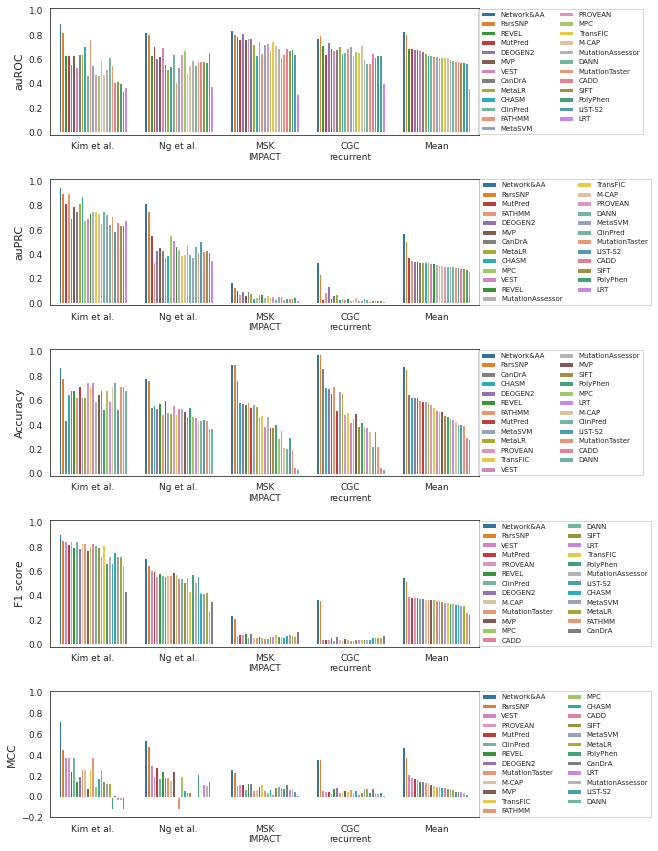

In [77]:
fig = plt.figure(figsize=(9.5, 12))
ax = plt.subplot(5, 1, 1)

df = auroc_df[auroc_df['metric']=='auROC'].copy()
ax = sns.barplot(x="dataset", y="score", hue="tool", data=df, palette=color_arr_roc)
plt.legend(ncol=2,loc='center',bbox_to_anchor=(1.19,0.5))
plt.ylabel('auROC'); plt.xlabel('')
plt.ylim(-0.02,1.02)


ax = plt.subplot(5, 1, 2)

df = auprc_df[auprc_df['metric']=='auPR'].copy()
ax = sns.barplot(x="dataset", y="score", hue="tool", data=df, palette=color_arr_pr)
plt.legend(ncol=2,loc='center',bbox_to_anchor=(1.2,0.5))
plt.ylabel('auPRC'); plt.xlabel('')
plt.ylim(-0.02,1.02)

ax = plt.subplot(5, 1, 3)

df = acc_df[acc_df['metric']=='Accuracy'].copy()
ax = sns.barplot(x="dataset", y="score", hue="tool", data=df, palette=color_arr_acc)
plt.legend(ncol=2,loc='center',bbox_to_anchor=(1.19,0.5))
plt.ylabel('Accuracy'); plt.xlabel('')
plt.ylim(-0.02,1.02)

ax = plt.subplot(5, 1, 4)

df = f1_df[f1_df['metric']=='F1'].copy()
ax = sns.barplot(x="dataset", y="score", hue="tool", data=df, palette=color_arr_f1)
plt.legend(ncol=2,loc='center',bbox_to_anchor=(1.2,0.5))
plt.ylabel('F1 score'); plt.xlabel('')
plt.ylim(-0.02,1.02)

ax = plt.subplot(5, 1, 5)

df = mcc_df[mcc_df['metric']=='MCC'].copy()
ax = sns.barplot(x="dataset", y="score", hue="tool", data=df, palette=color_arr_mcc)
plt.legend(ncol=2,loc='center',bbox_to_anchor=(1.2,0.5))
plt.ylabel('MCC'); plt.xlabel('')
plt.ylim(-0.2,1.02)

# fig.subplots_adjust(hspace=.25)
plt.tight_layout()

plt.savefig('../out/figures/Fig7.pdf', transparent=True, dpi=300)
plt.show()

### Combine performances (network-based methods only)

In [78]:
kim_df = kim_df.loc[tools_net].copy()
ng_df = ng_df.loc[tools_net].copy()
msk_df = msk_df.loc[tools_net].copy()
cgc_df = cgc_df.loc[tools_net].copy()

In [83]:
dataset_arr = ['kim','ng','msk','cgc']
tools2 = tools_net
dataset_dict = {'kim':'Kim et al.',
               'ng':'Ng et al.',
               'msk':'MSK\nIMPACT',
               'cgc':'CGC\nrecurrent'}
metrics_arr = list(cgc_df.columns)
print(metrics_arr)

['auROC', 'auPR', 'Accuracy', 'F1', 'MCC']


In [84]:
out_arr = list()
for d in dataset_arr:
    d_df = eval(d+'_df').copy()
    for t in tools2:
        for m in metrics_arr:
            s = d_df.loc[t][m]
            out_arr.append([dataset_dict[d],t,m,s])
combine_df = pd.DataFrame(out_arr, columns=['dataset','tool','metric','score'])
print(len(combine_df))

out_arr = list()
for t in tools2:
    for m in metrics_arr:
        s = np.mean(combine_df[(combine_df['tool']==t)&(combine_df['metric']==m)]['score'].values)
        out_arr.append(['mean',t,m,s])
print(len(out_arr), out_arr[:2])
temp_df = pd.DataFrame(out_arr, columns=['dataset','tool','metric','score'])
combine_df = pd.concat([combine_df, temp_df], ignore_index=True)
print(len(combine_df))
combine_df.tail()

60
15 [['mean', 'Network&AA', 'auROC', 0.8334663069912178], ['mean', 'Network&AA', 'auPR', 0.5712279557118108]]
75


,dataset,tool,metric,score
70,mean,Suspect,auROC,0.737146
71,mean,Suspect,auPR,0.405697
72,mean,Suspect,Accuracy,0.684183
73,mean,Suspect,F1,0.399181
74,mean,Suspect,MCC,0.223124


In [86]:
metric = 'auROC'
temp_df = combine_df[(combine_df['dataset']=='mean')&(combine_df['metric']==metric)].copy()
# tool_arr = temp_df.sort_values(['score'],ascending=False)['tool'].values
tool_arr = tools2
out_arr = list()
for d in dataset_arr:
    d_df = eval(d+'_df').copy()
    for t in tool_arr:
        for m in metrics_arr:
            s = d_df.loc[t][m]
            out_arr.append([dataset_dict[d],t,m,s])
merge_df = pd.DataFrame(out_arr, columns=['dataset','tool','metric','score'])
out_arr = list()
for t in tool_arr:
    for m in metrics_arr:
        s = np.mean(merge_df[(merge_df['tool']==t)&(merge_df['metric']==m)]['score'].values)
        out_arr.append(['Mean',t,m,s])
temp_df = pd.DataFrame(out_arr, columns=['dataset','tool','metric','score'])
merge_df = pd.concat([merge_df, temp_df], ignore_index=True)
auroc_df = merge_df.copy()
# color_arr_roc = color_arr

In [87]:
current_palette = sns.color_palette("tab10",len(tools2))

In [88]:
metric = 'auPR'
temp_df = combine_df[(combine_df['dataset']=='mean')&(combine_df['metric']==metric)].copy()
# tool_arr = temp_df.sort_values(['score'],ascending=False)['tool'].values
tool_arr = tools2
# color_arr = [color_dict[tool] for tool in tool_arr]
out_arr = list()
for d in dataset_arr:
    d_df = eval(d+'_df').copy()
    for t in tool_arr:
        for m in metrics_arr:
            s = d_df.loc[t][m]
            out_arr.append([dataset_dict[d],t,m,s])
merge_df = pd.DataFrame(out_arr, columns=['dataset','tool','metric','score'])
out_arr = list()
for t in tool_arr:
    for m in metrics_arr:
        s = np.mean(merge_df[(merge_df['tool']==t)&(merge_df['metric']==m)]['score'].values)
        out_arr.append(['Mean',t,m,s])
temp_df = pd.DataFrame(out_arr, columns=['dataset','tool','metric','score'])
merge_df = pd.concat([merge_df, temp_df], ignore_index=True)
auprc_df = merge_df.copy()
# color_arr_pr = color_arr

In [89]:
metric = 'Accuracy'
temp_df = combine_df[(combine_df['dataset']=='mean')&(combine_df['metric']==metric)].copy()
# tool_arr = temp_df.sort_values(['score'],ascending=False)['tool'].values
tool_arr = tools2
# color_arr = [color_dict[tool] for tool in tool_arr]
out_arr = list()
for d in dataset_arr:
    d_df = eval(d+'_df').copy()
    for t in tool_arr:
        for m in metrics_arr:
            s = d_df.loc[t][m]
            out_arr.append([dataset_dict[d],t,m,s])
merge_df = pd.DataFrame(out_arr, columns=['dataset','tool','metric','score'])
out_arr = list()
for t in tool_arr:
    for m in metrics_arr:
        s = np.mean(merge_df[(merge_df['tool']==t)&(merge_df['metric']==m)]['score'].values)
        out_arr.append(['Mean',t,m,s])
temp_df = pd.DataFrame(out_arr, columns=['dataset','tool','metric','score'])
merge_df = pd.concat([merge_df, temp_df], ignore_index=True)
acc_df = merge_df.copy()
# color_arr_acc = color_arr

In [90]:
metric = 'F1'
temp_df = combine_df[(combine_df['dataset']=='mean')&(combine_df['metric']==metric)].copy()
# tool_arr = temp_df.sort_values(['score'],ascending=False)['tool'].values
tool_arr = tools2
# color_arr = [color_dict[tool] for tool in tool_arr]
out_arr = list()
for d in dataset_arr:
    d_df = eval(d+'_df').copy()
    for t in tool_arr:
        for m in metrics_arr:
            s = d_df.loc[t][m]
            out_arr.append([dataset_dict[d],t,m,s])
merge_df = pd.DataFrame(out_arr, columns=['dataset','tool','metric','score'])
out_arr = list()
for t in tool_arr:
    for m in metrics_arr:
        s = np.mean(merge_df[(merge_df['tool']==t)&(merge_df['metric']==m)]['score'].values)
        out_arr.append(['Mean',t,m,s])
temp_df = pd.DataFrame(out_arr, columns=['dataset','tool','metric','score'])
merge_df = pd.concat([merge_df, temp_df], ignore_index=True)
f1_df = merge_df.copy()
# color_arr_f1 = color_arr

In [91]:
metric = 'MCC'
temp_df = combine_df[(combine_df['dataset']=='mean')&(combine_df['metric']==metric)].copy()
# tool_arr = temp_df.sort_values(['score'],ascending=False)['tool'].values
tool_arr = tools2
# color_arr = [color_dict[tool] for tool in tool_arr]
out_arr = list()
for d in dataset_arr:
    d_df = eval(d+'_df').copy()
    for t in tool_arr:
        for m in metrics_arr:
            s = d_df.loc[t][m]
            out_arr.append([dataset_dict[d],t,m,s])
merge_df = pd.DataFrame(out_arr, columns=['dataset','tool','metric','score'])
out_arr = list()
for t in tool_arr:
    for m in metrics_arr:
        s = np.mean(merge_df[(merge_df['tool']==t)&(merge_df['metric']==m)]['score'].values)
        out_arr.append(['Mean',t,m,s])
temp_df = pd.DataFrame(out_arr, columns=['dataset','tool','metric','score'])
merge_df = pd.concat([merge_df, temp_df], ignore_index=True)
mcc_df = merge_df.copy()
# color_arr_mcc = color_arr

### Figure S4

In [92]:
mpl.rc('legend', fontsize=8)
mpl.rc('xtick', labelsize=9)
mpl.rc('ytick', labelsize=9)
mpl.rc('axes', labelsize=11)

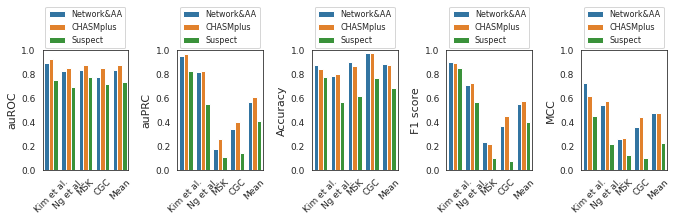

In [94]:
fig = plt.figure(figsize=(9.5, 3.6))
ax = plt.subplot(1, 5, 1)

df = auroc_df[auroc_df['metric']=='auROC'].copy()
ax = sns.barplot(x="dataset", y="score", hue="tool", data=df, palette=current_palette)
plt.legend(ncol=1,loc='upper center',bbox_to_anchor=(0.5,1.4))
plt.ylabel('auROC'); plt.xlabel('')
plt.ylim(0,1)
plt.xticks(rotation=45)
ax.set_xticklabels(['Kim et al.','Ng et al.','MSK','CGC','Mean'])

ax = plt.subplot(1, 5, 2)

df = auprc_df[auprc_df['metric']=='auPR'].copy()
ax = sns.barplot(x="dataset", y="score", hue="tool", data=df, palette=current_palette)
plt.legend(ncol=1,loc='upper center',bbox_to_anchor=(0.5,1.4))
plt.ylabel('auPRC'); plt.xlabel('')
plt.ylim(0,1)
plt.xticks(rotation=45)
ax.set_xticklabels(['Kim et al.','Ng et al.','MSK','CGC','Mean'])

ax = plt.subplot(1, 5, 3)

df = acc_df[acc_df['metric']=='Accuracy'].copy()
ax = sns.barplot(x="dataset", y="score", hue="tool", data=df, palette=current_palette)
plt.legend(ncol=1,loc='upper center',bbox_to_anchor=(0.5,1.4))
plt.ylabel('Accuracy'); plt.xlabel('')
plt.ylim(0,1)
plt.xticks(rotation=45)
ax.set_xticklabels(['Kim et al.','Ng et al.','MSK','CGC','Mean'])

ax = plt.subplot(1, 5, 4)

df = f1_df[f1_df['metric']=='F1'].copy()
ax = sns.barplot(x="dataset", y="score", hue="tool", data=df, palette=current_palette)
plt.legend(ncol=1,loc='upper center',bbox_to_anchor=(0.5,1.4))
plt.ylabel('F1 score'); plt.xlabel('')
plt.ylim(0,1)
plt.xticks(rotation=45)
ax.set_xticklabels(['Kim et al.','Ng et al.','MSK','CGC','Mean'])

ax = plt.subplot(1, 5, 5)

df = mcc_df[mcc_df['metric']=='MCC'].copy()
ax = sns.barplot(x="dataset", y="score", hue="tool", data=df, palette=current_palette)
plt.legend(ncol=1,loc='upper center',bbox_to_anchor=(0.5,1.4))
plt.ylabel('MCC'); plt.xlabel('')
plt.ylim(0,1)
plt.xticks(rotation=45)
ax.set_xticklabels(['Kim et al.','Ng et al.','MSK','CGC','Mean'])

plt.tight_layout()
# fig.subplots_adjust(wspace=.5)

plt.savefig('../out/figures/FigS4.pdf', transparent=True, dpi=300)
plt.show()